In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['aggregate', 'fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [2]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [3]:
region = 'Austin'
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values
region = 'SanDiego'
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [33]:
case = 2
a = 2
b = 3
cost = 'l21'

In [34]:
H_au = {}
A_au = {}
T_au = {}

In [35]:
# Learn H factors from aggregate Readings From Austin
num_homes = au_tensor.shape[0]
print num_homes
agg_au_tensor = au_tensor[:, 0, :].copy().reshape(num_homes, 1, 12)
print agg_au_tensor.shape
H, A, T, H_aus, A_aus, T_aus, HAT_aus, costs_aus = learn_HAT_adagrad(case, agg_au_tensor, a, b, num_iter=5000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))

533
(533, 1, 12)


In [36]:
H_au['aggregate'] = H.copy()
A_au['aggregate'] = A.copy()
T_au['aggregate'] = T.copy()

In [38]:
for appliance in APPLIANCES_ORDER[1:]:
    index = APPLIANCES_ORDER.index(appliance)
    tensor_copy = au_tensor[:, index, :].copy().reshape(num_homes, 1, 12)
    print appliance, index
    H_au[appliance], A_au[appliance], T_au[appliance], H_aus, A_aus, T_aus, HAT_aus, costs_aus = learn_HAT_adagrad(case, tensor_copy, a, b+index, num_iter=5000, lr=0.1, dis=False, cost_function=cost, H_known = H_au['aggregate'], T_known = T_au[APPLIANCES_ORDER[index-1]])

hvac 1
fridge 2
mw 3
dw 4
wm 5
oven 6


In [42]:
A_au['aggregate'][0]

array([[ 5.74485934,  8.42619918,  8.28302307],
       [ 5.97335446,  7.47154668,  8.3841105 ]])

In [44]:
A = np.zeros((7, 2, 9))

In [50]:
for appliance in APPLIANCES_ORDER:
    index = APPLIANCES_ORDER.index(appliance)
    A[index] = set_known(A[index], A_au[appliance][0])

In [ ]:
n_splits = 10
case = 2
a = 2
b = 9
cost = 'l21'

pred_transfer = {}
pred_normal = {}

for random_seed in range(10):
    pred_transfer[random_seed] = {}
    pred_normal[random_seed] = {}
  
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_normal[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
           
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            
            ############################################################################################
            # Normal learning with constant: with constant, no A_known, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=5000, lr=0.1, dis=False, cost_function=cost, T_known = np.ones(12).reshape(-1,1))
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
           
            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=5000, lr=0.1, dis=False, cost_function=cost, A_known = A, T_known = np.ones(12).reshape(-1,1))
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')


In [ ]:
out_normal = {}
for random_seed in range(10):
    out_normal[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_normal[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [55]:
out_transfer = {}
for random_seed in range(10):
    out_transfer[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [57]:
mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)

# df_out_normal = pd.DataFrame(out_normal)]
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})


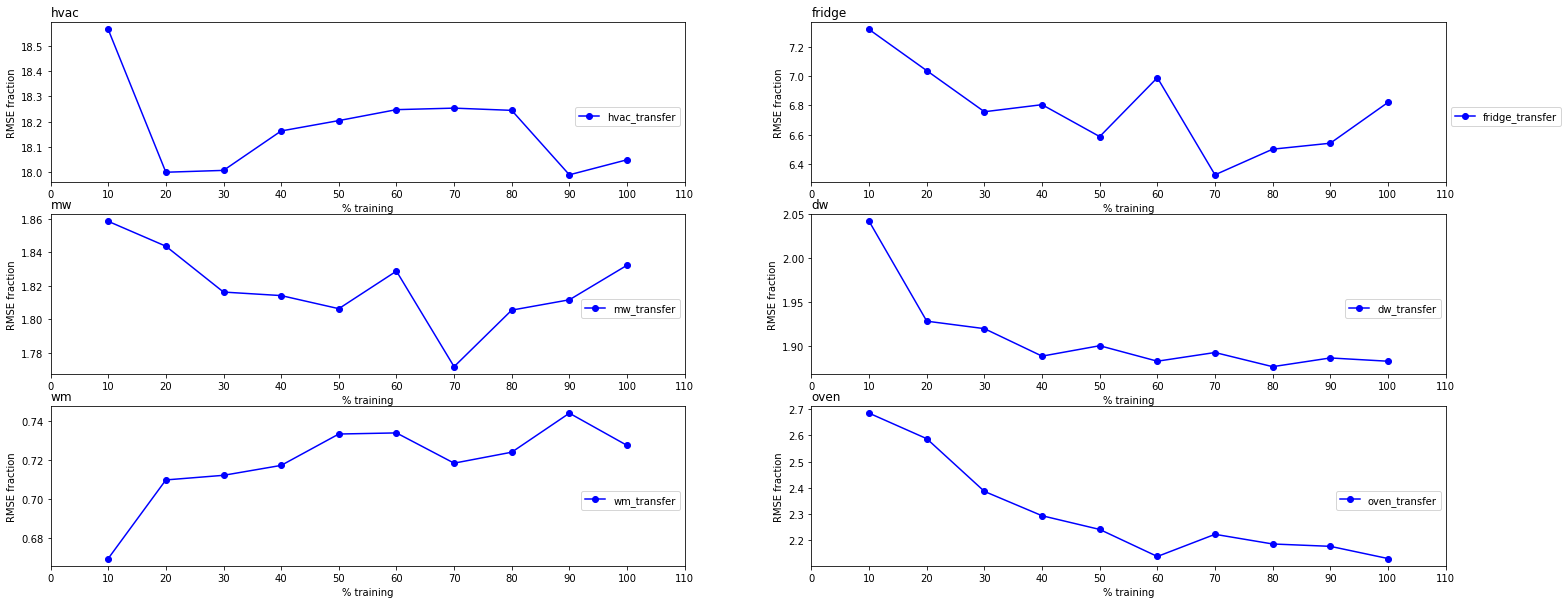

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(50, 80))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df = mean_out_transfer[appliance+"_transfer"]
    pd.DataFrame(df).plot(ax=ax[count],figsize=(25, 10), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
# plt.savefig("./analysis/0711/prediction_normal_transfer", bbox_inches="tight", dpi=300)